In [ ]:
# ===== INSTALLATION CELL =====
!pip install -q pandas numpy tensorflow matplotlib

In [ ]:
# ===== IMPORTS =====
import os
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from typing import Tuple, List
from tensorflow import keras
layers = keras.layers


In [ ]:
# ===== CONFIGURATION =====
DATASET_PATH = "/content/drive/MyDrive/Dataset"
OUTPUT_PATH = "/content/drive/MyDrive/Output"

In [ ]:
# Network params
INPUT_DIM = 16
HIDDEN_DIM = 128
OUT_DIMENSION = 2  # (x, y)

# Training params
BATCH_SIZE = 32
LEARNING_RATE = 0.005
NUM_EPOCHS = 50

In [ ]:
# ===== DATA LOADING (tf_data.py) =====
class CenterDataset:
    """
    It loads pairs of sensor CSV and center target CSV, producing:
      - sensor tensor of shape (1, 1, 16) in channels_last layout
      - target tensor of shape (2,) for (x, y)
    """

    def __init__(self,
                 dataset_path: str,
                 data_type: str = "Threshold20g",
                 sensor_file: str = "calibrated_sensor_data.csv",
                 center_file: str = "center_of_mass_estimate.csv",
                 output_data_type: str = "CAMERA"):
        self.dataset_path = Path(dataset_path)
        self.data_type_path = self.dataset_path / data_type
        self.sensor_file = sensor_file
        self.center_file = center_file
        self.output_data_type = output_data_type
        self.samples = self._load_samples()

    def _load_samples(self) -> List[Tuple[str, str]]:
        samples: List[Tuple[str, str]] = []
        if not self.data_type_path.exists():
            return samples
        for shape_dir in [d for d in self.data_type_path.iterdir() if d.is_dir()]:
            for recording_dir in [d for d in shape_dir.iterdir() if d.is_dir()]:
                sensor_file_path = recording_dir / self.sensor_file
                center_file_path = recording_dir / self.center_file
                if sensor_file_path.exists() and center_file_path.exists():
                    samples.append((str(sensor_file_path), str(center_file_path)))
        return samples

    def __len__(self) -> int:
        return len(self.samples)

    def _load_sensor(self, path: str) -> np.ndarray:
        # Load columns 1..16 (skip first index column)
        try:
            df = pd.read_csv(path, usecols=range(1, 17))
            if df.shape[1] != 16:
                raise ValueError(f"Expected 16 sensor columns, got {df.shape[1]}")
            values = df.values.astype(np.float32)
            if values.ndim == 2 and values.shape[0] == 1:
                vec16 = values[0]
            else:
                vec16 = values.mean(axis=0)
            # channels_last target input: (1, 1, 16)
            return vec16.reshape((1, 1, 16))
        except Exception:
            return np.zeros((1, 1, 16), dtype=np.float32)

    def _load_target(self, path: str) -> np.ndarray:
        try:
            df = pd.read_csv(path)
            if self.output_data_type not in df.columns:
                raise ValueError(f"{self.output_data_type} column not found in {path}")
            cam_vals = df[self.output_data_type].values.astype(np.float32)
            if cam_vals.size < 2:
                raise ValueError("Expected at least 2 rows for target")
            return cam_vals[:2]
        except Exception:
            return np.zeros((2,), dtype=np.float32)

    def to_tf_dataset(self,
                      batch_size: int = 32,
                      shuffle: bool = True,
                      seed: int = 42) -> tf.data.Dataset:
        # Guard: no samples
        if len(self.samples) == 0:
            raise ValueError("No paired samples found. Check dataset_path/data_type and file names.")

        def _py_load(sensor_path, center_path):
            sensor_path = sensor_path.decode("utf-8")
            center_path = center_path.decode("utf-8")
            x = self._load_sensor(sensor_path)
            y = self._load_target(center_path)
            return x.astype(np.float32), y.astype(np.float32)

        def _tf_map(sensor_path, center_path):
            x, y = tf.numpy_function(_py_load, [sensor_path, center_path], [tf.float32, tf.float32])
            x.set_shape((1, 1, 16))
            y.set_shape((2,))
            return x, y

        # Build from python lists to avoid numpy squeezing when only one sample
        sensors, centers = zip(*self.samples)
        ds = tf.data.Dataset.from_tensor_slices((list(sensors), list(centers)))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(self.samples), seed=seed, reshuffle_each_iteration=True)
        ds = ds.map(_tf_map, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds


def create_datasets(dataset_path: str,
                    data_type: str = "Threshold20g",
                    batch_size: int = 32,
                    train_split: float = 0.8,
                    val_split: float = 0.1,
                    test_split: float = 0.1,
                    seed: int = 42) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    dataset = CenterDataset(dataset_path, data_type)
    n = len(dataset)
    train_size = int(train_split * n)
    val_size = int(val_split * n)
    test_size = n - train_size - val_size

    rng = np.random.default_rng(seed)
    indices = np.arange(n)
    rng.shuffle(indices)
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]

    samples = list(dataset.samples)
    # Build lists of tuples using python indexing to preserve 2D structure even for singletons
    train_samples = [samples[i] for i in train_idx.tolist()]
    val_samples = [samples[i] for i in val_idx.tolist()]
    test_samples = [samples[i] for i in test_idx.tolist()]

    # helper to build ds from specific sample array
    def _build_from_samples(sample_list, shuffle: bool) -> tf.data.Dataset:
        tmp_ds = CenterDataset(dataset_path, data_type)
        tmp_ds.samples = list(sample_list)
        return tmp_ds.to_tf_dataset(batch_size=batch_size, shuffle=shuffle, seed=seed)

    return (
        _build_from_samples(train_samples, shuffle=True),
        _build_from_samples(val_samples, shuffle=False),
        _build_from_samples(test_samples, shuffle=False),
    )



In [ ]:
# ===== MODEL BUILDING =====
class ConvNetwork(keras.Model):
    def __init__(self, input_dim: int, hidden_dim: int = 128, out_dimension: int = 2):
        super().__init__()
        self.input_dim = input_dim
        self.out_dimension = out_dimension if out_dimension is not None else input_dim

        # Depthwise conv with multiplier=3
        self.depthwise = layers.DepthwiseConv2D(
            kernel_size=3,
            padding="same",
            depth_multiplier=3,
            use_bias=False,
            data_format="channels_last",
        )
        # Pointwise conv to hidden_dim
        self.pointwise = layers.Conv2D(
            filters=hidden_dim,
            kernel_size=1,
            padding="valid",
            activation=None,
            data_format="channels_last",
        )
        self.relu = layers.ReLU()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(self.out_dimension)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        # Expect inputs shape: (batch, 1, 1, input_dim)
        x = self.depthwise(inputs)
        x = self.pointwise(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


def build_model(input_dim: int, hidden_dim: int = 128, out_dimension: int = 2) -> keras.Model:
    # Functional API wrapper with static input shape for easier summary/saving
    inputs = keras.Input(shape=(1, 1, input_dim))
    x = layers.DepthwiseConv2D(
        kernel_size=3,
        padding="same",
        depth_multiplier=3,
        use_bias=False,
        data_format="channels_last",
        name="depthwise",
    )(inputs)
    x = layers.Conv2D(
        filters=hidden_dim,
        kernel_size=1,
        padding="valid",
        activation=None,
        data_format="channels_last",
        name="pointwise",
    )(x)
    x = layers.ReLU(name="relu")(x)
    x = layers.Flatten(name="flatten")(x)
    outputs = layers.Dense(out_dimension, name="fc")(x)
    model = keras.Model(inputs, outputs, name="ConvNetwork")
    return model



In [ ]:
 # ===== PLOTTING UTILITIES =====
def plot_history(history: tf.keras.callbacks.History, out_path: str) -> None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    if "mae" in history.history:
        plt.plot(history.history["mae"], label="Train MAE")
    if "val_mae" in history.history:
        plt.plot(history.history["val_mae"], label="Val MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.title("Training and Validation MAE")

    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()


def plot_results(y_true: np.ndarray, y_pred: np.ndarray, out_dir: str, tag: str) -> None:
    os.makedirs(out_dir, exist_ok=True)
    err = y_pred - y_true
    l2_err = np.linalg.norm(err, axis=1)

    # Scatter plots true vs pred
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true[:, 0], y_pred[:, 0], s=8, alpha=0.6)
    lims = [min(y_true[:, 0].min(), y_pred[:, 0].min()), max(y_true[:, 0].max(), y_pred[:, 0].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel('True X')
    plt.ylabel('Pred X')
    plt.title('True vs Pred X')

    plt.subplot(1, 2, 2)
    plt.scatter(y_true[:, 1], y_pred[:, 1], s=8, alpha=0.6)
    lims = [min(y_true[:, 1].min(), y_pred[:, 1].min()), max(y_true[:, 1].max(), y_pred[:, 1].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel('True Y')
    plt.ylabel('Pred Y')
    plt.title('True vs Pred Y')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'scatter_true_vs_pred_{tag}.png'))
    plt.show()

    # Error histogram
    plt.figure(figsize=(6, 4))
    plt.hist(l2_err, bins=30, alpha=0.8)
    plt.xlabel('L2 error')
    plt.ylabel('Count')
    plt.title('L2 Error Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'error_hist_{tag}.png'))
    plt.show()


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    err = y_pred - y_true
    mae = np.mean(np.abs(err), axis=0)
    rmse = np.sqrt(np.mean(err ** 2, axis=0))
    mae_total = float(np.mean(np.abs(err)))
    rmse_total = float(np.sqrt(np.mean(err ** 2)))
    return {
        "mae_x": float(mae[0]),
        "mae_y": float(mae[1]),
        "rmse_x": float(rmse[0]),
        "rmse_y": float(rmse[1]),
        "mae": mae_total,
        "rmse": rmse_total,
    }



In [ ]:
# ===== TRAINING FUNCTION =====
def train_tf_model():
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    print("Loading datasets...")
    train_ds, val_ds, test_ds = create_datasets(
        dataset_path=DATASET_PATH,
        data_type="Threshold20g",
        batch_size=BATCH_SIZE,
        train_split=0.7,
        val_split=0.15,
        test_split=0.15,
        seed=42,
    )

    print("Building model...")
    model = build_model(INPUT_DIM, HIDDEN_DIM, OUT_DIMENSION)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
    )

    model.summary()

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    ckpt_path = os.path.join(OUTPUT_PATH, f"centre_regressor_{timestamp}.keras")

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=ckpt_path,
            save_best_only=True,
            monitor="val_loss",
            mode="min",
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
    ]

    print("Starting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=NUM_EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    # Evaluate
    print("\nEvaluating on test set...")
    eval_res = model.evaluate(test_ds, verbose=1)
    print("Test results:", dict(zip(model.metrics_names, eval_res)))

    # Plot curves
    plot_path = os.path.join(OUTPUT_PATH, f"tf_training_curves_{timestamp}.png")
    plot_history(history, plot_path)
    print(f"Saved training curves to {plot_path}")

    # Save final model
    final_path = os.path.join(OUTPUT_PATH, f"centre_regressor_final_{timestamp}.keras")
    model.save(final_path)
    print(f"Saved model to {final_path}")

    return model, history, timestamp



In [ ]:
# ===== EVALUATION FUNCTION =====
def evaluate_model(model_path: str, data_type: str = "Threshold20g", batch_size: int = 32):
    print(f"Loading model from {model_path}...")

    # Build datasets with the same split ratios used in training
    train_ds, val_ds, test_ds = create_datasets(
        dataset_path=DATASET_PATH,
        data_type=data_type,
        batch_size=batch_size,
        train_split=0.7,
        val_split=0.15,
        test_split=0.15,
        seed=42,
    )

    # Reconstruct test sample list deterministically to align predictions and targets
    full_ds = CenterDataset(DATASET_PATH, data_type)
    n = len(full_ds)
    train_size = int(0.7 * n)
    val_size = int(0.15 * n)
    test_size = n - train_size - val_size
    rng = np.random.default_rng(42)
    indices = np.arange(n)
    rng.shuffle(indices)
    test_idx = indices[train_size + val_size:]
    test_samples = [full_ds.samples[i] for i in test_idx.tolist()]

    print(f"Loaded {len(test_samples)} test samples")

    model = tf.keras.models.load_model(model_path)
    preds = model.predict(test_ds, verbose=1)

    # Load ground-truth targets for test_samples in order
    def load_target(path: str) -> np.ndarray:
        try:
            df = pd.read_csv(path)
            vals = df[full_ds.output_data_type].values.astype(np.float32)
            return vals[:2]
        except Exception:
            return np.zeros((2,), dtype=np.float32)

    y_true = np.stack([load_target(center) for _, center in test_samples], axis=0)
    y_pred = preds.astype(np.float32)

    metrics = compute_metrics(y_true, y_pred)
    print("Overall metrics:", metrics)

    # Save per-sample predictions
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    csv_path = os.path.join(OUTPUT_PATH, f"tf_predictions_{timestamp}.csv")
    rows = []
    for (sensor_path, center_path), yp, yt in zip(test_samples, y_pred, y_true):
        err = yp - yt
        rows.append({
            'sensor_path': sensor_path,
            'center_path': center_path,
            'true_x': float(yt[0]),
            'true_y': float(yt[1]),
            'pred_x': float(yp[0]),
            'pred_y': float(yp[1]),
            'err_x': float(err[0]),
            'err_y': float(err[1]),
            'err_l2': float(np.linalg.norm(err)),
        })
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"Saved predictions to {csv_path}")

    # Plots
    plot_results(y_true, y_pred, OUTPUT_PATH, tag=timestamp)
    print(f"Saved plots to {OUTPUT_PATH}")

    return metrics, y_true, y_pred



In [ ]:
model, history, timestamp = train_tf_model()

In [ ]:
import os

# Check if dataset path exists
print("Does DATASET_PATH exist?", os.path.exists(DATASET_PATH))
print("DATASET_PATH is set to:", DATASET_PATH)

Does DATASET_PATH exist? True
DATASET_PATH is set to: /content/drive/MyDrive/Dataset


In [ ]:
# List what's in /content
print("\nContents of /content/:")
print(os.listdir('/content'))


Contents of /content/:
['.config', 'drive', 'sample_data']


In [ ]:
# If you mounted Google Drive, check there
if os.path.exists('/content/drive'):
    print("\nGoogle Drive is mounted!")


Google Drive is mounted!


In [ ]:
def evaluate_model(model_path: str, data_type: str = "Threshold20g", batch_size: int = 32):
    print(f"Loading model from {model_path}...")

    # Build datasets with the same split ratios used in training
    train_ds, val_ds, test_ds = create_datasets(
        dataset_path=DATASET_PATH,
        data_type=data_type,
        batch_size=batch_size,
        train_split=0.7,
        val_split=0.15,
        test_split=0.15,
        seed=42,
    )

    # Reconstruct test sample list deterministically to align predictions and targets
    full_ds = CenterDataset(DATASET_PATH, data_type)
    n = len(full_ds)
    train_size = int(0.7 * n)
    val_size = int(0.15 * n)
    test_size = n - train_size - val_size
    rng = np.random.default_rng(42)
    indices = np.arange(n)
    rng.shuffle(indices)
    test_idx = indices[train_size + val_size:]
    test_samples = [full_ds.samples[i] for i in test_idx.tolist()]

    print(f"Loaded {len(test_samples)} test samples")

    model = tf.keras.models.load_model(model_path)
    preds = model.predict(test_ds, verbose=1)

    # Load ground-truth targets for test_samples in order
    def load_target(path: str) -> np.ndarray:
        try:
            df = pd.read_csv(path)
            vals = df[full_ds.output_data_type].values.astype(np.float32)
            return vals[:2]
        except Exception:
            return np.zeros((2,), dtype=np.float32)

    y_true = np.stack([load_target(center) for _, center in test_samples], axis=0)
    y_pred = preds.astype(np.float32)

    metrics = compute_metrics(y_true, y_pred)
    print("Overall metrics:", metrics)

    # Save per-sample predictions
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    csv_path = os.path.join(OUTPUT_PATH, f"tf_predictions_{timestamp}.csv")
    rows = []
    for (sensor_path, center_path), yp, yt in zip(test_samples, y_pred, y_true):
        err = yp - yt
        rows.append({
            'sensor_path': sensor_path,
            'center_path': center_path,
            'true_x': float(yt[0]),
            'true_y': float(yt[1]),
            'pred_x': float(yp[0]),
            'pred_y': float(yp[1]),
            'err_x': float(err[0]),
            'err_y': float(err[1]),
            'err_l2': float(np.linalg.norm(err)),
        })
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"Saved predictions to {csv_path}")

    # Plots
    plot_results(y_true, y_pred, OUTPUT_PATH, tag=timestamp)
    print(f"Saved plots to {OUTPUT_PATH}")

    return metrics, y_true, y_pred


# ===== OVERFIT CHECK FUNCTION  =====
def overfit_check():
    print("Running overfit check on single batch...")
    train_ds, _, _ = create_datasets(
        dataset_path=DATASET_PATH,
        data_type="Threshold20g",
        batch_size=8,
        train_split=1.0,
        val_split=0.0,
        test_split=0.0,
        seed=123,
    )

    model = build_model(16, 64, 2)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train_ds.take(1).repeat(200), epochs=50, verbose=1)
    print("Overfit check complete!")
    return history



Loading model from /content/drive/MyDrive/Output/centre_regressor_final_2025-11-20_11-43.keras...
Loaded 122 test samples
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 14s/step
Overall metrics: {'mae_x': 3.837907314300537, 'mae_y': 4.080442428588867, 'rmse_x': 5.0955071449279785, 'rmse_y': 5.13961124420166, 'mae': 3.959174394607544, 'rmse': 5.117607116699219}
Saved predictions to /content/drive/MyDrive/Output/tf_predictions_2025-11-28_09-32.csv


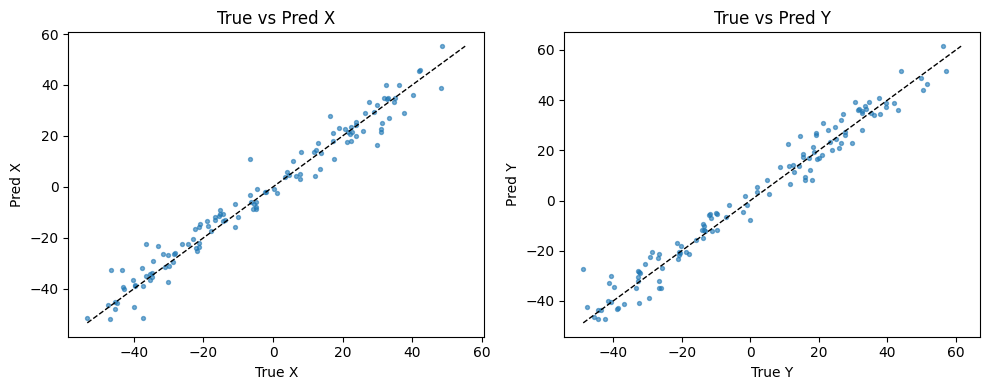

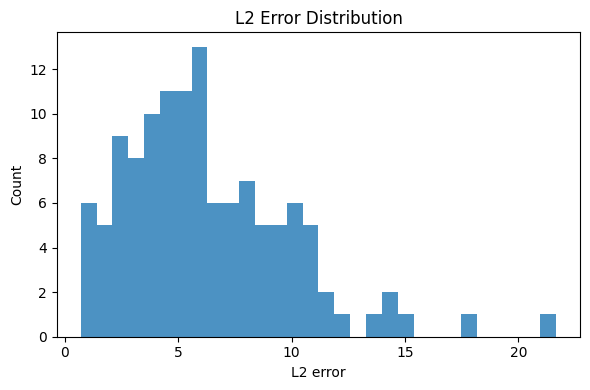

Saved plots to /content/drive/MyDrive/Output


In [ ]:
# Evaluate a saved model
metrics, y_true, y_pred = evaluate_model('/content/drive/MyDrive/Output/centre_regressor_final_2025-11-20_11-43.keras')

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
model = tf.keras.models.load_model("/content/drive/MyDrive/Output/centre_regressor_final_2025-11-20_11-43.keras")



# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Provide a representative dataset for full integer quantization

def representative_dataset():
    count = 0
    # create_datasets returns (train_ds, val_ds, test_ds)
    # Correctly unpack the three datasets into variables
    train_ds, _, _ = create_datasets(DATASET_PATH, "Threshold20g", BATCH_SIZE,
                                            0.8, 0.1, 0.1, 42)
    # Iterate over the batches from the training dataset
    # Each element from train_ds is a tuple (batch_sensor_data, batch_target_data)
    for batch_sensor_data, _ in train_ds:
        for i in range(batch_sensor_data.shape[0]):
            if count >= 100:
                return # Stop generating after 100 samples
            sample = batch_sensor_data[i:i+1]  # Get a single sample with shape (1, 1, 1, 16)
            yield [sample] # Yield it as a list, as expected by TFLiteConverter
            count += 1
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()
# Save the model to disk
open("nn_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("nn_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmp7aj_y6pn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 1, 16), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132473036067408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132473036067984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132473036073552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132473036071824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132473036067216: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model is 14496 bytes


In [ ]:
# Verify
interpreter = tf.lite.Interpreter(model_path="nn_model.tflite")
interpreter.allocate_tensors()

# Get input details
input_details = interpreter.get_input_details()
print("Input quantization params:")
print("Scale:", input_details[0]['quantization'][0])
print("Zero point:", input_details[0]['quantization'][1])
output_details = interpreter.get_output_details()
print("Output quantization params:")
print("Scale:", output_details[0]['quantization'][0])
print("Zero point:", output_details[0]['quantization'][1])

Input quantization params:
Scale: 0.9795611500740051
Zero point: -77
Output quantization params:
Scale: 0.402652770280838
Zero point: -2


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat nn_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

In [ ]:
import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 89,426 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
